In [60]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt 
import scipy.sparse
import matplotlib.patches as mpatches
import itertools
import random
import matplotlib.cm
import glob
from matplotlib import font_manager
from utils.lists import *
from matplotlib_venn import venn2, venn2_circles

from upsetplot import generate_counts
from upsetplot import plot
from upsetplot import UpSet
from upsetplot import from_memberships

import warnings
warnings.filterwarnings('ignore')

# Fig. 5a Celltype peak categories

In [17]:
peaks_dir = '/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/peaks_df/'

arr = np.zeros((7,4))
for ii,celltype in enumerate(['EXC','OLI','INH','OPC','MIC','END','AST']):
    df = pd.read_csv(peaks_dir+f'{celltype}.peaks_df.csv',sep=',')
    vals = df.peakType.value_counts().values
    arr[ii] = vals

In [3]:
# Total number of peaks
total = arr.sum()

In [4]:
# percent intronic
arr[:,0].sum()/total

np.float64(0.5112523899631943)

In [5]:
# percent distal
arr[:,1].sum()/total

np.float64(0.26151313809418014)

In [6]:
arr = arr/1e3

In [7]:
arr = pd.DataFrame(arr,index=['EXC','OLI','INH','OPC','MIC','END','AST'],columns=['Intronic','Distal','Promoter','Exonic'])

In [13]:
celltypes = ['EXN','OLG','IN','OPC','MG','END','AST']
colors = list(celltype_colors2.values())
fc_colors = []
for a in [1,0.7,0.4,0.1]:
    for c in colors:
        fc_color = (np.append(list(matplotlib.colors.to_rgb(c)),a))
        fc_colors.append(fc_color)

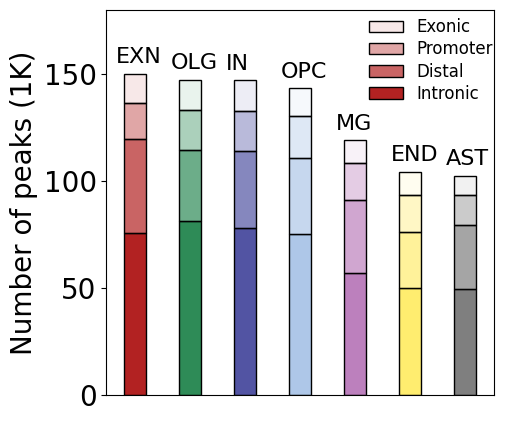

In [16]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size']= '20'

plt.rcParams.update({'hatch.color': 'white'})

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylabel('Number of peaks (1K)')
ax.set_ylim([0,180])
ax.get_xaxis().set_visible(False)

ax.bar(celltypes,arr.values[:,0],width=0.4,label='Intronic',color=fc_colors[:7],ec=(0,0,0,1))
ax.bar(celltypes,arr.values[:,1],bottom=arr.values[:,0],width=0.4,label='Distal',color=fc_colors[7:14],ec=(0,0,0,1))
ax.bar(celltypes,arr.values[:,2],bottom=arr.values[:,0]+arr.values[:,1],width=0.4,label='Promoter',color=fc_colors[14:21],ec=(0,0,0,1))
ax.bar(celltypes,arr.values[:,3],bottom=arr.values[:,0]+arr.values[:,1]+arr.values[:,2],width=0.4,label='Exonic',color=fc_colors[21:],ec=(0,0,0,1))

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]

for ii,c,y in zip(np.arange(7)-0.35,celltypes,arr.sum(axis=1).values+5):
    ax.text(ii,y,c,fontsize=16)
            
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=12,frameon=False,bbox_to_anchor=(0.64,0.72),labelspacing=0.25) 

plt.savefig('/home/ah2428/palmer_scratch/figs/fig5/peak_categories.pdf',bbox_inches='tight',dpi=300)

# Fig. 5b Peaks upset plot

In [54]:
jaccard = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/peaks/jaccard_outs.txt',sep='\t',header=None)

In [55]:
mat = pd.DataFrame(jaccard[3].values.reshape((7,7)),index=['EXN','OLG','IN','OPC','MG','END','AST'],columns=['EXN','OLG','IN','OPC','MG','END','AST'])

In [56]:
mat = mat/1000

In [61]:
memberships = [['EXN'],['EXN','IN'],['EXN','OPC'],['EXN','OLG'],
         ['OLG'],['OLG','OPC'],['OLG','IN'],['OLG','END'],
         ['IN'],['IN','OPC'],['IN','END'],['IN','AST'],
         ['OPC'],['OPC','AST'],['OPC','END'],['OPC','MG'],
         ['MG'],['MG','END'],['MG','OLG'],['MG','IN'],
         ['END'],['END','EXN'],['END','AST'],
         ['AST'],['AST','OLG'],['AST','EXN']]
vals = []
for m in memberships:
    if len(m)==1:
        val = mat[m[0]][m[0]]
    else:
        val = mat[m[0]][m[1]]
    vals.append(val)
ex = from_memberships(memberships,data=vals)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

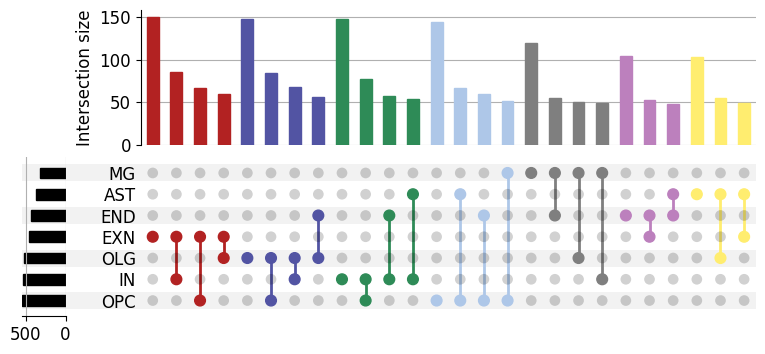

In [62]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = '12'
upset = UpSet(ex,sort_by=None,element_size=22)
upset.style_subsets(present=['EXN'],absent=['AST','END','MG'],facecolor='#b22222')
upset.style_subsets(present=['OLG'],absent=['AST','MG','EXN'],facecolor='#5254a3')
upset.style_subsets(present=['IN'],absent=['OLG','MG','EXN'],facecolor='#2E8B57')
upset.style_subsets(present=['OPC'],absent=['OLG','EXN','IN'],facecolor='#aec7e8')
upset.style_subsets(present=['MG'],absent=['OPC','EXN','AST'],facecolor='#7f7f7f')
upset.style_subsets(present=['END'],absent=['OPC','OLG','IN','MG'],facecolor='#bc80bd')
upset.style_subsets(present=['AST'],absent=['IN','MG','OPC','END'],facecolor='#ffed6f')

upset.plot()
plt.savefig('/home/ah2428/palmer_scratch/figs/fig5/upset_plot.pdf',bbox_inches='tight',dpi=300)

# Fig. 5d CRE donut plot

In [63]:
p2g = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/p2glinks_maxDist_2M.csv',sep='\t')

In [64]:
p2g = p2g[p2g.Correlation > 0.4][p2g.FDR < 0.05]

In [65]:
p2g = p2g.drop_duplicates(subset=['peakName'])

In [66]:
union = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/peaks/union_peaks_meta.bed',sep='\t')

In [67]:
union = union[['peak','peakType']]

In [68]:
cre = union[union.peak.isin(p2g.peakName.values)].value_counts('peakType')

In [69]:
round(union[union.peak.isin(p2g.peakName.values)].shape[0]/union.shape[0],2)

0.89

In [70]:
c='#b22222'
colors = []
for a in [1,0.7,0.1,0.4]:
    color = (np.append(list(matplotlib.colors.to_rgb(c)),a))
    colors.append(color)

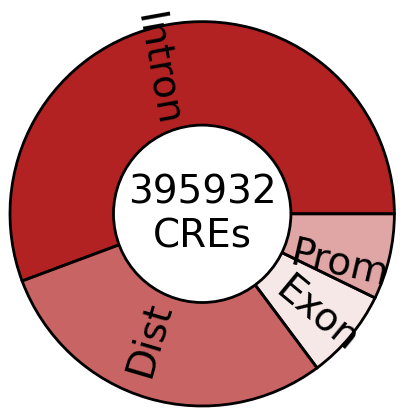

In [71]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = '28'

names = cre.index.values
size = cre.values
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.6, edgecolor='k', facecolor='white', linewidth=2)

# Custom wedges
fig, ax = plt.subplots()
pie, text = ax.pie(size, labels=['Intron','Dist','Exon','Prom'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'black' }, colors=colors, rotatelabels=True,labeldistance=0.45, radius=1.3)

p=plt.gcf()
p.gca().add_artist(my_circle)

ax.text(0., 0., str(cre.values.sum())+'\nCREs', horizontalalignment='center', verticalalignment='center')
plt.savefig('/home/ah2428/palmer_scratch/figs/fig5/CRE_donut.pdf',bbox_inches='tight',dpi=300)

# Fig. 5e CLG-DEG 

In [72]:
p2g = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/ATAC/data/p2glinks_maxDist_2M.csv',sep='\t')
cre = p2g[p2g.Correlation > 0.4][p2g.FDR < 0.05]

In [73]:
cre_meta = pd.read_csv('/home/ah2428/palmer_scratch/supp_tables/CRE_metadata.csv',sep='\t')

In [74]:
len(cre.peakName.unique())

395932

In [75]:
cre_meta['chr'] = [x.split(':')[0] for x in cre_meta['CRE'].values]
cre_meta['start'] = [x.split(':')[1].split('-')[0] for x in cre_meta['CRE'].values]
cre_meta['end'] = [x.split(':')[1].split('-')[1] for x in cre_meta['CRE'].values]
cre_meta['peakName'] = cre_meta['chr']+'_'+cre_meta['start']+'_'+cre_meta['end']

In [82]:
deg = pd.read_csv('/home/ah2428/palmer_scratch/supp_tables/txt/PTSD_DEG_MAST_and_Wilcox.txt',sep='\t')

In [80]:
deg

,Genename,Geneid,Description,Celltype,MAST log2FC,MAST FDR,Wilcox log2FC,Wilcox FDR
0,AAMP,ENSG00000127837,angio associated migratory cell protein [Sourc...,CUX2,0.468326,2.434250e-167,0.341706,3.296808e-32
1,AAMP,ENSG00000127837,angio associated migratory cell protein [Sourc...,EXN,0.407247,1.902389e-259,0.346678,1.650536e-94
2,AAMP,ENSG00000127837,angio associated migratory cell protein [Sourc...,FEZF2,0.277644,2.350548e-14,0.345229,8.324716e-07
3,AAMP,ENSG00000127837,angio associated migratory cell protein [Sourc...,OPRK1,0.369263,1.532996e-18,0.362893,4.981851e-15
4,AAMP,ENSG00000127837,angio associated migratory cell protein [Sourc...,RORB,0.351898,6.869485e-61,0.331708,1.121517e-31
...,...,...,...,...,...,...,...,...
2835,ZNF804B,ENSG00000182348,zinc finger protein 804B [Source:HGNC Symbol;A...,VIP,-0.406489,1.732768e-18,-0.307300,5.602609e-16
2836,ZNF84,ENSG00000198040,zinc finger protein 84 [Source:HGNC Symbol;Acc...,MG,-0.312239,1.436209e-04,-0.457602,7.479009e-20
2837,ZNRF3,ENSG00000183579,zinc and ring finger 3 [Source:HGNC Symbol;Acc...,END,-0.579826,2.347003e-14,-0.271494,5.625677e-39
2838,ZPR1,ENSG00000109917,ZPR1 zinc finger [Source:HGNC Symbol;Acc:HGNC:...,CUX2,0.323956,1.103868e-84,0.273217,4.668905e-14


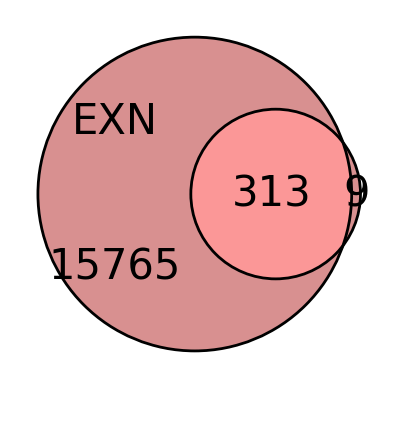

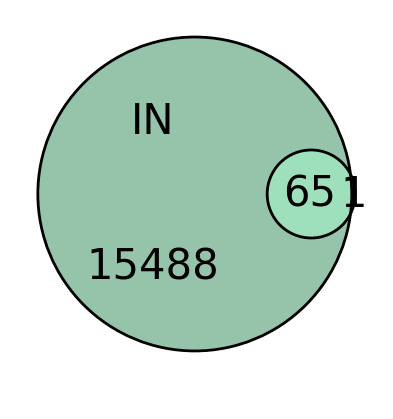

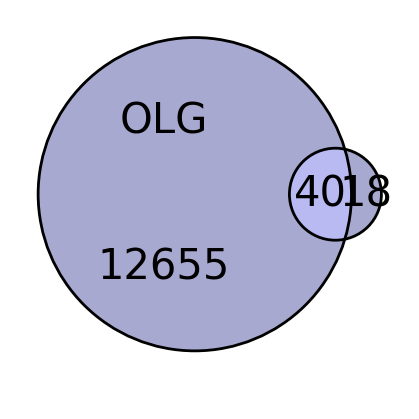

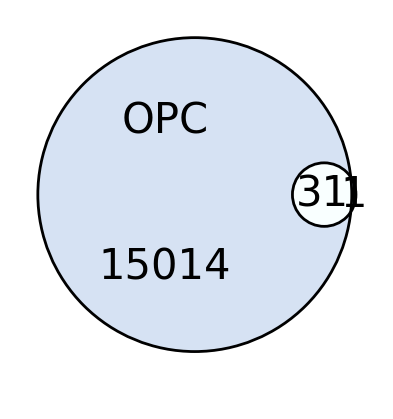

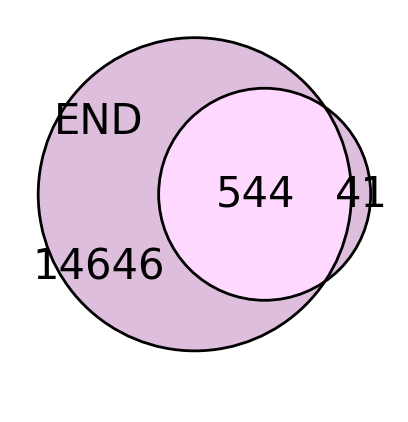

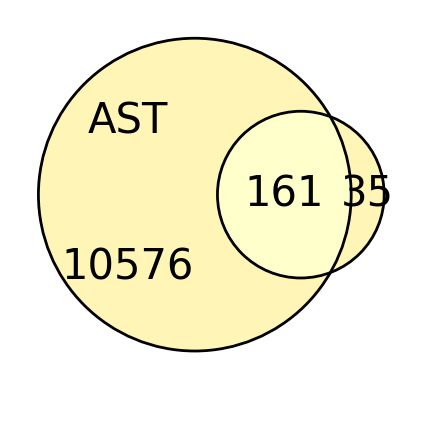

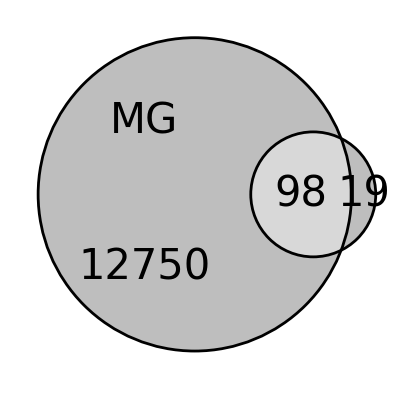

In [83]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = '30'

colors = list(celltype_colors2.values())

num_inters = []
inter_genes = []
for ii,cell in zip(np.arange(len(celltypes)),['EXN','IN','OLG','OPC','END','AST','MG']):
    cell_cres = cre_meta[cre_meta.Celltype==cell].peakName.values
    cell_p2g = cre[cre.peakName.isin(cell_cres)]
    clgs = cell_p2g.geneName.unique()
    degs = deg[deg['Celltype']==cell].Genename.values
    inter = list(set(clgs)&set(degs))
    inter_genes.append(inter)
    num_inters.append(len(inter))
    plt.figure()
    v = venn2(subsets = ( (len(clgs)-len(inter))*0.05, len(degs)-len(inter), len(inter)),
        set_colors=(colors[ii],colors[ii]),
        set_labels=(' ',' '),
        alpha=0.5,
    )
    c = venn2_circles(subsets = ( (len(clgs)-len(inter))*0.05, len(degs)-len(inter), len(inter)),color='black')

    v.get_label_by_id('10').set_text(str(len(clgs)-len(inter)))
    v.get_label_by_id('100').set_text(f'{cell}\n\n\n{len(clgs)-len(inter)}')